In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [3]:
spark = SparkSession.builder.enableHiveSupport().appName('AmazonReviewRcommender').getOrCreate()
sc = spark.sparkContext

### Load kcore_5.json

In [4]:
# Load kcore_5.json
df = spark.read.json("/user/ywang27/data_final/kore_5.json")

In [16]:
df.show(2)

+----------+-------+-------+--------------------+-----------+--------------+------------+--------------------+--------------+
|      asin|helpful|overall|          reviewText| reviewTime|    reviewerID|reviewerName|             summary|unixReviewTime|
+----------+-------+-------+--------------------+-----------+--------------+------------+--------------------+--------------+
|0000013714| [0, 0]|    4.0|We use this type ...| 12 3, 2013| ACNGUPJ3A3TM9|         GCM|         Nice Hymnal|    1386028800|
|0000013714| [2, 3]|    5.0|I bought this for...|09 13, 2009|A2SUAM1J3GNN3B| J. McDonald|Heavenly Highway ...|    1252800000|
+----------+-------+-------+--------------------+-----------+--------------+------------+--------------------+--------------+
only showing top 2 rows



In [17]:
df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



### Write to Hive

In [4]:
from pyspark.sql import HiveContext
hive_context = HiveContext(sc)

In [22]:
hive_context.sql("use ywang27")
hive_context.sql("show tables").show()
hive_context.sql("drop table if exists kcore_5")

+--------+--------------------+-----------+
|database|           tableName|isTemporary|
+--------+--------------------+-----------+
| ywang27|      chicago_crimes|      false|
| ywang27|  chicago_crimes_orc|      false|
| ywang27|chicago_crimes_sm...|      false|
| ywang27|chicago_crimes_sm...|      false|
| ywang27|             kcore_5|      false|
+--------+--------------------+-----------+



DataFrame[]

In [23]:
df.write.mode('overwrite').saveAsTable('kcore_5')

In [25]:
hive_context.sql("select count(*) from kcore_5").show()

+--------+
|count(1)|
+--------+
|41135700|
+--------+



### Load metadata.json

In [5]:
df1 = spark.read.json("/user/ywang27/data_final/metadata/metadata.json")

In [19]:
df1.show(2)

+---------------+----------+-----+--------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+
|_corrupt_record|      asin|brand|          categories|         description|               imUrl|price|             related|           salesRank|               title|
+---------------+----------+-----+--------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+
|           null|0001048791| null|           [[Books]]|                null|http://ecx.images...| null|                null|[,,,,, 6334800,,,...|The Crucible: Per...|
|           null|0000143561| null|[[Movies & TV, Mo...|3Pack DVD set - I...|http://g-ecx.imag...|12.99|[, [B0036FO6SI, B...|[,,,,,,,,,,,,,,,,...|Everyday Italian ...|
+---------------+----------+-----+--------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------

In [20]:
df1.printSchema()

root
 |-- _corrupt_record: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)
 |-- description: string (nullable = true)
 |-- imUrl: string (nullable = true)
 |-- price: double (nullable = true)
 |-- related: struct (nullable = true)
 |    |-- also_bought: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- also_viewed: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- bought_together: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- buy_after_viewing: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |-- salesRank: struct (nullable = true)
 |    |-- Appliances: long (nullable = true)
 |    |-- Arts, Crafts & Sewing: long (nullable = true)
 |    |-- Automotive: long

### Join metadata with kcore_5

In [6]:
df2 = df.join(df1, df.asin == df1.asin, "inner").select(
    df.asin, 
    df.helpful,
    df.overall, 
    df.reviewText, 
    df.reviewerID,
    df1.categories,
    df1.price,
    df1.related,
    df1.title
)

In [6]:
df2.show(5)

+----------+-------+-------+--------------------+--------------+----------+-----+--------------------+---------------+
|      asin|helpful|overall|          reviewText|    reviewerID|categories|price|             related|          title|
+----------+-------+-------+--------------------+--------------+----------+-----+--------------------+---------------+
|0002216973| [1, 1]|    5.0|And to me, there'...| AESMLAZX4PI6L| [[Books]]| null|[, [0812823354, 0...|Red Adam's Lady|
|0002216973| [1, 1]|    5.0|From the dust jac...| AMVV8VYDTLA78| [[Books]]| null|[, [0812823354, 0...|Red Adam's Lady|
|0002216973| [1, 1]|    5.0|There are only a ...| AHCOCJHM388I7| [[Books]]| null|[, [0812823354, 0...|Red Adam's Lady|
|0002216973| [0, 0]|    5.0|I bought this boo...| ACUJMLOJEVYTB| [[Books]]| null|[, [0812823354, 0...|Red Adam's Lady|
|0002216973| [0, 0]|    5.0|I was looking out...|A39CS2IZHTQVJH| [[Books]]| null|[, [0812823354, 0...|Red Adam's Lady|
+----------+-------+-------+--------------------

In [7]:
df2.count()

33282097

### Number of items per categories

In [34]:
categories_num: list = df2.groupBy(df2.categories[0][0]).count().sort("count", ascending=False).collect()

In [35]:
categories_num

[Row(categories[0][0]='Books', count=9115768),
 Row(categories[0][0]='Electronics', count=3398224),
 Row(categories[0][0]='Clothing, Shoes & Jewelry', count=2059979),
 Row(categories[0][0]='Movies & TV', count=1989636),
 Row(categories[0][0]='Home & Kitchen', count=1985213),
 Row(categories[0][0]='Health & Personal Care', count=1468117),
 Row(categories[0][0]='Cell Phones & Accessories', count=1297057),
 Row(categories[0][0]='Apps for Android', count=1295382),
 Row(categories[0][0]='Sports & Outdoors', count=1260001),
 Row(categories[0][0]='CDs & Vinyl', count=1234729),
 Row(categories[0][0]='Beauty', count=932096),
 Row(categories[0][0]='Tools & Home Improvement', count=859274),
 Row(categories[0][0]='Toys & Games', count=833469),
 Row(categories[0][0]='Grocery & Gourmet Food', count=665808),
 Row(categories[0][0]='Pet Supplies', count=643913),
 Row(categories[0][0]='Video Games', count=581174),
 Row(categories[0][0]='Office Products', count=580039),
 Row(categories[0][0]='Automotive'

## WordCloud

In [110]:
from pyspark.sql.functions import split, explode, lower

# including stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words("english")

# add some non-sense words
stop_words += ['', "-", "many", '"', "go", "one", "much", "get", "also", "would", "make", "i'm", "i've", "us", "going",
               "could", "made", "every", "another", "things", "may", "come", "know", "way", "see", "put", "say", "got",
               "looking", "look", "give", "since", "next", "think", "thought", "bit", "little", "makes", "must", "lot",
               "find", "done", "still", "everything", "might", "wanted", "&", ")", "takes", "anything", "nothing", 
               "said", "that's", "5", "2", "gives", "--", "making", "given", "often", "comes", "getting", "set", 
               "able", "away", "felt", "using", "1", "3", "4", "6", "7", "8", "9", "use", "feel", "used"]

In [129]:
primary_type = "CDs & Vinyl"
df_type_review = df2.select("reviewText").where(df2.categories[0][0] == primary_type)
# df_type_review.count()

In [130]:
# https://spark.apache.org/docs/latest/api/python/reference/pyspark.pandas/api/pyspark.pandas.DataFrame.explode.html?highlight=explode
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.functions.split.html?highlight=split#pyspark.sql.functions.split

# split the text by space and punctuations and convert to multiple rows
df_type_review_word = df_type_review.select(explode(split(lower(df_type_review.reviewText), '[\s,.!?]')).alias('words'))
# df_type_review_word.show(20)

In [131]:
# https://spark.apache.org/docs/latest/api/python/reference/pyspark.pandas/api/pyspark.pandas.groupby.GroupBy.count.html?highlight=count

# count the top 100 word frequency and export to 
df_type_review_word = df_type_review_word.groupBy(
    df_type_review_word.words).count().sort(
    "count", ascending=False)

In [132]:
# https://stackoverflow.com/questions/19960077/how-to-filter-pandas-dataframe-using-in-and-not-in-like-in-sql

# filter out stopwords
df_type_review_word_list = df_type_review_word.select("words", "count").where(
    ~df_type_review_word.words.isin(stop_words)).limit(200).collect()
df_type_review_word_list

[Row(words='album', count=1344225),
 Row(words='like', count=779316),
 Row(words='music', count=760023),
 Row(words='songs', count=698922),
 Row(words='cd', count=679180),
 Row(words='song', count=634947),
 Row(words='great', count=621094),
 Row(words='good', count=503944),
 Row(words='love', count=395326),
 Row(words='best', count=381290),
 Row(words='first', count=362950),
 Row(words='really', count=356183),
 Row(words='sound', count=351509),
 Row(words='time', count=346311),
 Row(words='band', count=324698),
 Row(words='well', count=300045),
 Row(words='even', count=262770),
 Row(words='new', count=252027),
 Row(words='track', count=246320),
 Row(words='albums', count=244864),
 Row(words='listen', count=232257),
 Row(words='rock', count=228941),
 Row(words='tracks', count=226954),
 Row(words='better', count=211554),
 Row(words='heard', count=201677),
 Row(words='two', count=194301),
 Row(words='years', count=193124),
 Row(words='back', count=190858),
 Row(words='never', count=187439

In [133]:
# generate world frequencies for world cloud
plot_dict = {}
for item in df_type_review_word_list:
    plot_dict[item[0]] = item[1]

In [49]:
!pip install wordcloud --user

  Using cached https://files.pythonhosted.org/packages/05/e7/52e4bef8e2e3499f6e96cc8ff7e0902a40b95014143b062acde4ff8b9fc8/wordcloud-1.8.1-cp36-cp36m-manylinux1_x86_64.whl
  The script wordcloud_cli is installed in '/home/ywang27/.local/bin' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You are using pip version 10.0.1, however version 21.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [50]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

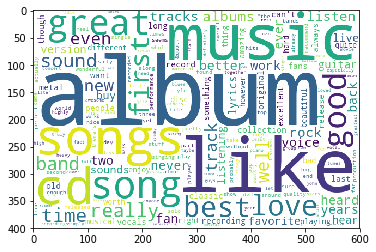

In [134]:
# https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud.WordCloud

# generate plot
wc = WordCloud(width=600, height=400, background_color="white", max_words=200)
wc.generate_from_frequencies(plot_dict)
wc.to_file(f"./wordcloud/{primary_type}.png")
plt.imshow(wc)

### Word Clouds for Top 10 reviewed categories of product

Books

![](./wordcloud/Books.png)

Electronics

![](./wordcloud/Electronics.png)

Clothing

![](./wordcloud/Electronics.png)

Movies & TV

![](./wordcloud/Movies & TV.png)

Home & Kitchen

![](./wordcloud/Home & Kitchen.png)

Health & Personal Care

![](./wordcloud/Health & Personal Care.png)

Cell Phone & Accessories

![](./wordcloud/Cell Phones & Accessories.png)

Apps for Android

![](./wordcloud/Apps for Android.png)

Sports & Outdoors

![](./wordcloud/Sports & Outdoors.png)

CDs & Vinyl

![](./wordcloud/CDs & Vinyl.png)